
"""
Created on Tue Feb 22 14:42:56 2022
@author: uqczhan2
if hydraulic conductivity of the sandy layer
is reduced, the large hydraulic conductivity in the oscillating boundary
needs to be redued accordingLy_m 
"""

In [1]:
# -*- coding: utf-8 -*-
import sys
import glob
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.3
matplotlib version: 3.4.3
pandas version: 1.3.4
flopy version: 3.3.5


In [3]:
Lx_m   = 1000.    # from plot, y is plotted from left to right
Ly_m   = 10.     # from plot, y is plotted upward
ztop_m = 0.    # top elevation of z axis (gravity)
zbot_m = -20.  # bottom elevation of z axis (gravity)
nlay = 10    # number of layers (gravity)
nrow = 1     # number of rows
ncol = 10
delr_m = Lx_m / ncol
delc_m = Ly_m / nrow
delv_m = (ztop_m - zbot_m) / nlay             # layer thickness
botm_list_m = np.linspace(ztop_m, zbot_m, nlay + 1)  # layer elevation array
hk = np.ones((nlay, nrow, ncol), dtype=np.int32) * 20. #*30.   
# making hydraulic conductivity array  [lay_row_column]
hk[:,:,0]= 100.     # first column has a very high hydraulic conductivity
vka = hk
sy = 0.25    # specific yield, equivalent to effective porosity
ss = 1.e-4   #  specific storitivity 
laytyp = np.ones(nlay)   # unconfined = 1 

In [4]:
ibound = np.zeros((nlay, nrow, ncol), dtype=np.int32) + 3    # [lay_row_column] active cell has ibound of 3
lay_id_chd = nlay-1  # the cell at bottom left will be prescribed with chd package.  
row_id_chd = 0
col_id_chd = 0
ibound_chd = 1  # the cell prescibed with chd package are masked with ibound of 1
# # why 3-D here?? because the model is 3-d, with one row
ibound[lay_id_chd,row_id_chd,col_id_chd] = ibound_chd   

In [5]:
# interesting to see that the it is better to be converged, if the head is above zero 
strt = -15. * np.ones((nlay, nrow, ncol), dtype=np.float32)   # initial hydraulic head
nper   = 3                  # number of stress periods
perlen = [100, 100, 100]    # length of stress periods  days 
nstp   = [100, 100, 100]    # number of steps per stress periods
steady = [False, False, False]   # if the results needs to be in steady state

In [6]:
modelname = 'tutorial2'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')
dis = flopy.modflow.ModflowDis(mf, 
                               nlay, 
                               nrow, 
                               ncol, 
                               delr=delr_m, 
                               delc=delc_m,
                               top=ztop_m, botm=botm_list_m[1:],
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady,
                               itmuni=4)   #itmuni 4 means time unit is days
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# https://modflowpy.github.io/flopydoc/mflpf.html
head_dry_m=1e-30
lpf = flopy.modflow.ModflowLpf(mf, 
                               hk=hk, 
                               vka=vka, 
                               sy=sy, 
                               ss=ss, 
                               laytyp=laytyp, 
                               ipakcb=53,
                               hdry=head_dry_m,   # dry cell will be prescribed with a head of 1e-30
                               wetfct=0.1,
                               iwetit=3,
                               laywet=1,
                               wetdry=-1)
pcg = flopy.modflow.ModflowPcg(mf)

Text(0.5, 1.0, 'ibound values')

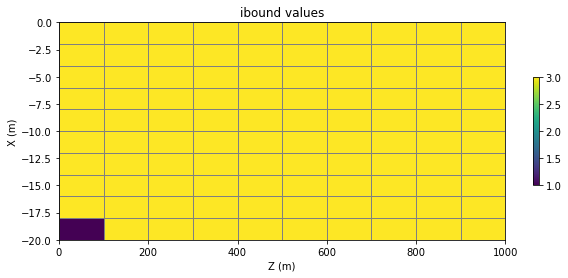

In [7]:
fig = plt.figure(figsize=(10, 4))
ax  = fig.add_subplot(1, 1, 1)
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(ibound)
modeLx_msect.plot_grid()
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_ylabel("X (m)")
ax.set_xlabel("Z (m)")
ax.set_title("ibound values")
#ax.legend()

In [8]:
ibound_chd_mask = np.ma.masked_equal(ibound,ibound_chd)
chd_node_index = np.where(ibound_chd_mask.mask)
stress_period_data = {}
bound_sp0 = []
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp0.append([chd_node_index[0][i], chd_node_index[1][i], chd_node_index[2][i] , -1 , -1]  )
bound_sp1=[]
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp1.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],-10,-10]  )
bound_sp2=[]
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp2.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],-0.1,-0.1]  )

stress_period_data={0:bound_sp0,1:bound_sp1,2:bound_sp2}

chd=flopy.modflow.mfchd.ModflowChd(model=mf,
                                   stress_period_data=stress_period_data)

In [9]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        if np.mod(kstp,49)==0:
            stress_period_data[(kper, kstp)] = ['save head',
                                                'save drawdown',
                                                'save budget',
                                                'print head',
                                                'print budget']
            
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,compact=True)

In [10]:
mf.write_input()

#### Run the model

In [11]:
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
        raise Exception('MODFLOW did not terminate normalLy_m.')

In [12]:
headobj = bf.HeadFile(modelname+'.hds')
times_headobj = headobj.get_times()
cbbobj = bf.CellBudgetFile(modelname+'.cbc')
times_cbbobj = cbbobj.get_times()
# beginning of the first stress period
times_output_list_day = [99, 101.0, 150,199,201,250,299]
print(times_cbbobj)

[1.0, 50.0, 99.0, 101.0, 150.0, 199.0, 201.0, 250.0, 299.0]


In [13]:
print(times_headobj)

[1.0, 50.0, 99.0, 101.0, 150.0, 199.0, 201.0, 250.0, 299.0]


In [35]:
dis.get_node_coordinates[0,0,0]

TypeError: 'method' object is not subscriptable

In [44]:
dis.get_rc_from_node_coordinates(5,1)

structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


(0, 0)

In [14]:
tsList = headobj.get_kstpkper()
head_array_timeid_lrc_m = np.empty([len(times_cbbobj)],object)
for i,j in enumerate(times_cbbobj):
    #print(i,j)
    head_array_timeid_lrc_m[i]=  headobj.get_data(totim=j)

In [15]:
tsList

[(0, 0), (49, 0), (98, 0), (0, 1), (49, 1), (98, 1), (0, 2), (49, 2), (98, 2)]

In [16]:
np.set_printoptions(suppress=False,precision=2)  #organise the matrix output better

In [17]:
def plot_head_distribution_watertable(output_time_index = 1):
    fig = plt.figure(figsize=(8, 3))
    ax  = fig.add_subplot(1, 1, 1)
    t   = ax.set_title('Head distribution at  day %i' %(times_output_list_day[output_time_index]))
    head = headobj.get_data(totim=times_output_list_day[output_time_index])
    modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
    arr = modeLx_msect.plot_array(head,masked_values= [head_dry_m])
    grd = modeLx_msect.plot_grid()
    ax.plot(dis.get_node_coordinates()[1] , head[-1,0,:], linewidth=5.0,)
    plt.colorbar(arr, shrink=1, ax=ax)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    times = cbbobj.get_times()
    qx = cbbobj.get_data(text="flow right face", totim=times[output_time_index])[0]
    qy = np.zeros((nlay, nrow, ncol), dtype=float)
    qz = cbbobj.get_data(text="flow lower face", totim=times[output_time_index])[0]
    modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)

Note dry cells are given as non-colored cells

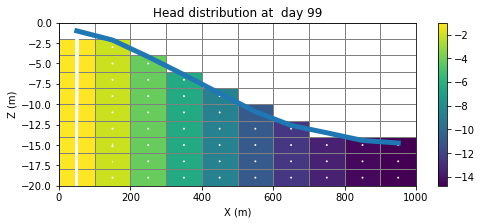

In [18]:
plot_head_distribution_watertable(output_time_index = 0)

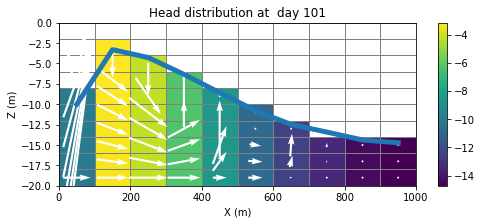

In [19]:
plot_head_distribution_watertable(output_time_index = 1)

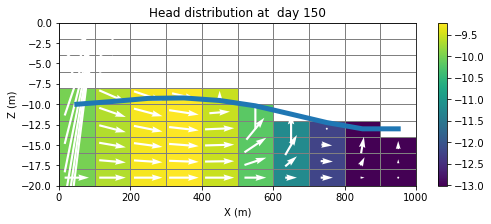

In [20]:
plot_head_distribution_watertable(output_time_index = 2)

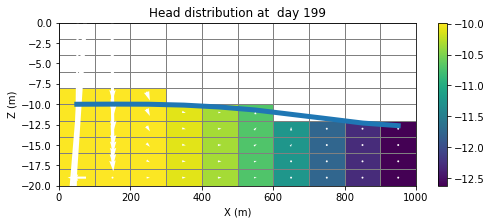

In [21]:
plot_head_distribution_watertable(output_time_index = 3)

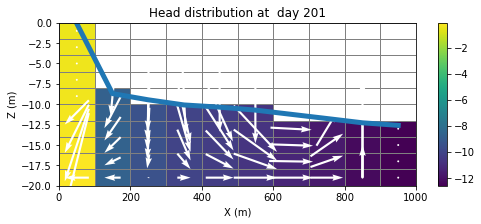

In [22]:
plot_head_distribution_watertable(output_time_index = 4)

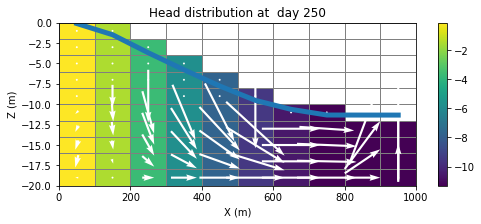

In [23]:
plot_head_distribution_watertable(output_time_index = 5)

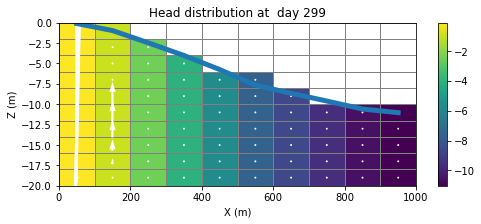

In [24]:
plot_head_distribution_watertable(output_time_index = 6)

In [29]:
head_array_301_m =np.array([i[3,0,1] for i in head_array_timeid_lrc_m[:]])
print(head_array_301_m)

[ 1.00e-30 -2.52e+00 -2.13e+00 -3.20e+00  1.00e-30  1.00e-30  1.00e-30
 -1.47e+00 -9.61e-01]


Text(0, 0.5, 'Head in Metres')

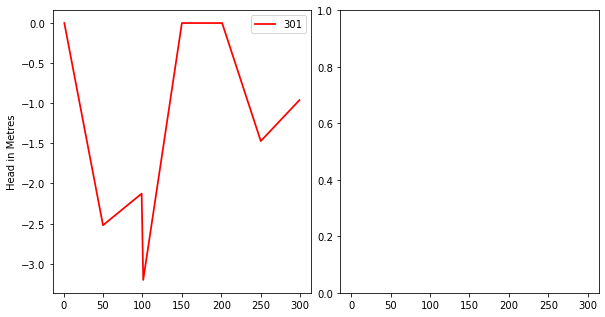

In [31]:

fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    sharex=True,
    figsize=(8.3, 4.3),
    constrained_layout=True,
)

# title_str ='kv = {:1.1e}'.format(Kv) + '_ lak_conc = {:1.1e}'.format(lak_conc) \
#     +'_ delc = {:1.1e}'.format(delc) + '_ lak_strt = {:1.1e}'.format(lak_strt) \
#     + '_ strt = {:1.1e}'.format(strt_head)
# fig.suptitle(title_str,fontsize=10)

ax = axes[0]
# ax.set_xlim(0, 1500)
# ax.set_ylim(110, 130)

head_array_301_m =np.array([i[3,0,1] for i in head_array_timeid_lrc_m[:]])
ax.plot(
    times_headobj,
    head_array_301_m,
    lw=1.75,
    ls="-",
    color="red",
    label="301",
)

# head_array_101_m =np.array([i[1,0,1] for i in head_array_stpper_lrc[:,0]])
# ax.plot(
#     results["time"][1:],
#     head_array_101_m,
#     lw=1.75,
#     ls="-",
#     color="green",
#     label="101",
# )

# head_array_202_m =np.array([i[2,0,2] for i in head_array_stpper_lrc[:,0]])
# ax.plot(
#     results["time"][1:],
#     head_array_202_m,
#     lw=1.75,
#     ls="-",
#     color="blue",
#     label="202",
# )


# head_array_303_m =np.array([i[3,0,3] for i in head_array_stpper_lrc[:,0]])
# ax.plot(
#     results["time"][1:],
#     head_array_303_m,
#     lw=1.75,
#     ls="-",
#     color="cyan",
#     label="303",
# )
ax.legend()
# ax.set_title("k"+)    
ax.set_ylabel("Head in Metres")
# fs.graph_legend(ax, loc="upper right")
# fs.heading(ax, idx=0)